# AR(1) + GARCH(1,1) Model

In [1]:
using Optim, PyPlot

include("jlFiles/printmat.jl")

printlnPs (generic function with 1 method)

In [2]:
xx  = readdlm("Data/FFdSizePs.csv",',',header=true)
xx  = xx[1]
ymd = xx[:,1]     #[YearMonthDay]
R   = xx[:,2]     #returns for the size portfolio we want to study
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(R,1)-1) R[1:end-1]]     #regressors, [1, y(t-1)]

8324×2 Array{Float64,2}:
 1.0  -1.18
 1.0  -1.37
 1.0   1.73
 1.0   0.77
 1.0   1.41
 1.0   0.68
 1.0   1.26
 1.0   0.61
 1.0   1.11
 1.0   0.63
 1.0   0.64
 1.0   0.37
 1.0   0.49
 ⋮         
 1.0  -0.52
 1.0  -0.3 
 1.0   0.18
 1.0   1.13
 1.0   1.11
 1.0  -0.11
 1.0   0.58
 1.0  -0.53
 1.0  -0.57
 1.0  -0.45
 1.0  -0.35
 1.0  -0.34

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$$
\begin{align*}
y_{t}           &  =x_{t}^{\prime}b+u_{t} \ \text{ with }\ u_{t}=v_{t}\sigma_{t}\\
\sigma_{t}^{2}  &  =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
\end{align*}
$$
Note that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is

$$
\ln\mathcal{L}=-\frac{T}{2}\ln\left(  2\pi\right)  -\frac{1}{2}\sum_{t=1}
^{T}\ln\sigma_{t}^{2}-\frac{1}{2}\sum_{t=1}^{T}\frac{u_{t}^{2}}{\sigma_{t}
^{2}}.
$$


The likelihood function of a GARCH(1,1) model can be coded as in
*garch11LL*. The first function calculates time-varying  variances and
the likelihood contributions (for each period). The second functions forms the
loss function used in the minimization.

In [3]:
function garch11LL(parm::Vector,y,x)

  (T,k) = size(x,1,2)

  b     = parm[1:k]         #mean equation, y = x'*b
  (omega,alpha,beta1) = abs.(parm[k+1:k+3])    #GARCH(1,1) equation: 
                                              #s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)        
  yhat = x*b
  u    = y - yhat
  s2_0 = var(u)                                 #var(u,1) gives a matrix, var(u) a scalar

  s2    = fill(NaN,T)
  s2[1] = omega + alpha*s2_0 + beta1*s2_0        #simple, but slow apparoach
  for t = 2:T                                    #using filter() is perhaps quicker
    s2[t] = omega + alpha*u[t-1]^2 + beta1*s2[t-1]
  end

  LL    = -(1/2)*log(2*pi) - (1/2)*log.(s2) - (1/2)*(u.^2)./s2
  LL[1] = 0               #effectively skip the first observation

  return LL,s2,yhat

end


function garch11LLLoss(parm::Vector,y,x)
    LL,  = garch11LL(parm::Vector,y,x)
    Loss =  -sum(LL)                  #to minimize: -sum(LL)
    return Loss
end


function garch11LLRLoss(parm::Vector,y,x,rho)     #with restriction on alpha+beta1 < 1
  LL, = garch11LL(parm,y,x)
  k = size(x,2)
  (omega,alpha,beta1) = abs.(parm[k+1:k+3])   #s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)
  g = [alpha + beta1 - 1]                     #alpha + beta1 < 1
  Loss = -sum(LL) + rho*sum(max.(0,g).^2)
  return Loss
end

garch11LLRLoss (generic function with 1 method)

## Maximize the Likelihood Function

In [4]:
#mean equation, y = x'b
#GARCH(1,1) equation: s2(t) = omega + alfa*u(t-1)^2 + beta1*s2(t-1)

par0 = [mean(y);0;var(y)*0.05;0.05;0.9]         #initial parameter guess

(loglik,s2,yhat) = garch11LL(par0,y,x)            #just testing the log lik
LL               = garch11LLLoss(par0,y,x)
printlnPs("Value of (-)log-likelihood fn at starting guess: ",LL)

Sol = optimize(par->garch11LLLoss(par,y,x),par0)   #do MLE by optimization with optimize, minimize -sum(LL)

parHat            = Optim.minimizer(Sol)          #extract the optimal solution 
parHat[end-2:end] = abs.(parHat[end-2:end])       #since the likelihood function uses abs(these values)

LLHat             = garch11LLLoss(parHat,y,x)
printlnPs("Value of (-)log-likelihood fn at estimate: ",LLHat)

println("\nParameter estimates (b[1],b[2],omega,alpha,beta1): ")
printmat(parHat)

Value of (-)log-likelihood fn at starting guess:   9231.913
Value of (-)log-likelihood fn at estimate:   8243.608

Parameter estimates (b[1],b[2],omega,alpha,beta1): 
     0.049
     0.256
     0.014
     0.162
     0.824



In [5]:
println("\nIterate with hard and harder punishment on α + β < 1 restriction. PERHAPS NOT NEEDED")

options = Optim.Options(show_trace=false,show_every=10)
for rho = 0.0:0.1:1
  Sol = optimize(par->garch11LLRLoss(par,y,x,rho),par0,options)
  par = Optim.minimizer(Sol)
  par[end-3:end-1] = abs.(par[end-3:end-1])
  printmat([rho par'])
  par0 = deepcopy(par)
end


Iterate with hard and harder punishment on α + β < 1 restriction. PERHAPS NOT NEEDED
     0.000     0.049     0.256     0.014     0.162     0.824

     0.100     0.049     0.256     0.014     0.162     0.824

     0.200     0.049     0.256     0.014     0.162     0.824

     0.300     0.049     0.256     0.014     0.162     0.824

     0.400     0.049     0.256     0.014     0.162     0.824

     0.500     0.049     0.256     0.014     0.162     0.824

     0.600     0.049     0.256     0.014     0.162     0.824

     0.700     0.049     0.256     0.014     0.162     0.824

     0.800     0.049     0.256     0.014     0.162     0.824

     0.900     0.049     0.256     0.014     0.162     0.824

     1.000     0.049     0.256     0.014     0.162     0.824



## Value at Risk

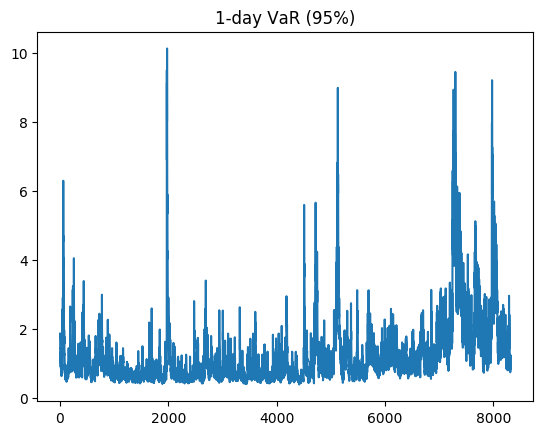


Coverage ratio for VaR(95%):      0.059


In [6]:
(_,s2,ER) = garch11LL(parHat,y,x)
VaR95     = -(ER - 1.64*sqrt.(s2))

figure()
  plot(VaR95)
title("1-day VaR (95%)")
show()

CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("\nCoverage ratio for VaR(95%): ",CovRatio)